<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### 1 - Preparación del entorno y carga de datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [69]:
# Instala librerías necesarias
!pip install --upgrade --no-cache-dir gdown --quiet


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
# Importa librerías necesarias
import os
import gdown
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [71]:
# Descargar el dataset
if not os.path.exists('data_volunteers.json'):
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)

# Cargar el dataset
with open('data_volunteers.json') as f:
    data = json.load(f)

# Limpiar el texto
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"\'d", " had", txt)
    txt = re.sub(r"\'s", " is", txt)
    txt = re.sub(r"\'m", " am", txt)
    txt = re.sub(r"don't", "do not", txt)
    txt = re.sub(r'\W+', ' ', txt)
    return txt.strip()

# Preparar los datos
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

for line in data:
    for i in range(len(line['dialog']) - 1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        if len(chat_in.split()) >= max_len or len(chat_out.split()) >= max_len:
            continue

        input_sentences.append(chat_in)
        output_sentences.append(chat_out + ' ')
        output_sentences_inputs.append(' ' + chat_out)

print(f"Cantidad de filas procesadas: {len(input_sentences)}")

Cantidad de filas procesadas: 13323


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

Es decir, se realiza el preprocesamiento para generar los índices de palabras y las secuencias de entrada y salida.

In [72]:
# Construir vocabularios
def build_vocab(sentences, max_vocab_size=20000):
    word_counts = Counter(word for sentence in sentences for word in sentence.split())
    vocab = ['<PAD>', '<START>', '<END>', '<UNK>'] + [word for word, _ in word_counts.most_common(max_vocab_size)]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

word2idx_inputs, idx2word_inputs = build_vocab(input_sentences)
word2idx_outputs, idx2word_outputs = build_vocab(output_sentences)

max_input_len = max(len(s.split()) for s in input_sentences)
max_output_len = max(len(s.split()) for s in output_sentences)

# Convertir palabras a índices
def sentences_to_sequences(sentences, word2idx, max_len):
    sequences = []
    for sentence in sentences:
        seq = [word2idx.get(word, word2idx['<UNK>']) for word in sentence.split()]
        seq = seq[:max_len] + [word2idx['<PAD>']] * (max_len - len(seq))
        sequences.append(seq)
    return np.array(sequences)

encoder_input_sequences = sentences_to_sequences(input_sentences, word2idx_inputs, max_input_len)
decoder_input_sequences = sentences_to_sequences(output_sentences_inputs, word2idx_outputs, max_output_len)
decoder_targets = sentences_to_sequences(output_sentences, word2idx_outputs, max_output_len)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores.Para transformar las palabras en vectores, se implementará GloVe o FastText. En esta oportinuidad, se usará GloVe.

In [73]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.01, 0.01, (len(word2idx), embedding_dim))
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word, vector = parts[0], np.array(parts[1:], dtype=np.float32)
            if word in word2idx:
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_dim = 100
embeddings_path = 'glove.6B.100d.txt'  # Asegúrate de tener el archivo descargado
input_embeddings = load_glove_embeddings(embeddings_path, word2idx_inputs, embedding_dim)
output_embeddings = load_glove_embeddings(embeddings_path, word2idx_outputs, embedding_dim)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase. 

Construcción del modelo Encoder-Decoder con LSTM. El modelo de secuencia a secuencia basado en LSTM tendrá dos componentes:

Encoder: Convertirá la entrada en un vector de contexto.

Decoder: Generará las respuestas a partir del vector de contexto.

In [74]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, c) = self.lstm(x)
        return h, c

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, h, c):
        x = self.embedding(x)
        x, (h, c) = self.lstm(x, (h, c))
        x = self.fc(x)
        return x, h, c


Entrenamiento:

Epoch 1/100, Loss: 7.2161, Accuracy: 0.0911, Val Loss: 5.6890, Val Accuracy: 0.1125
Epoch 2/100, Loss: 5.2880, Accuracy: 0.1084, Val Loss: 5.2555, Val Accuracy: 0.1248
Epoch 3/100, Loss: 5.0403, Accuracy: 0.1388, Val Loss: 5.0329, Val Accuracy: 0.1899
Epoch 4/100, Loss: 4.7860, Accuracy: 0.2118, Val Loss: 4.7630, Val Accuracy: 0.2444
Epoch 5/100, Loss: 4.5123, Accuracy: 0.2999, Val Loss: 4.4815, Val Accuracy: 0.3425
Epoch 6/100, Loss: 4.2348, Accuracy: 0.3450, Val Loss: 4.2043, Val Accuracy: 0.3690
Epoch 7/100, Loss: 3.9666, Accuracy: 0.3785, Val Loss: 3.9405, Val Accuracy: 0.4091
Epoch 8/100, Loss: 3.7126, Accuracy: 0.4301, Val Loss: 3.6937, Val Accuracy: 0.4660
Epoch 9/100, Loss: 3.4787, Accuracy: 0.4763, Val Loss: 3.4703, Val Accuracy: 0.5063
Epoch 10/100, Loss: 3.2668, Accuracy: 0.5104, Val Loss: 3.2683, Val Accuracy: 0.5475
Epoch 11/100, Loss: 3.0742, Accuracy: 0.5516, Val Loss: 3.0845, Val Accuracy: 0.5860
Epoch 12/100, Loss: 2.8981, Accuracy: 0.5868, Val Loss: 2.9168, Val Accura

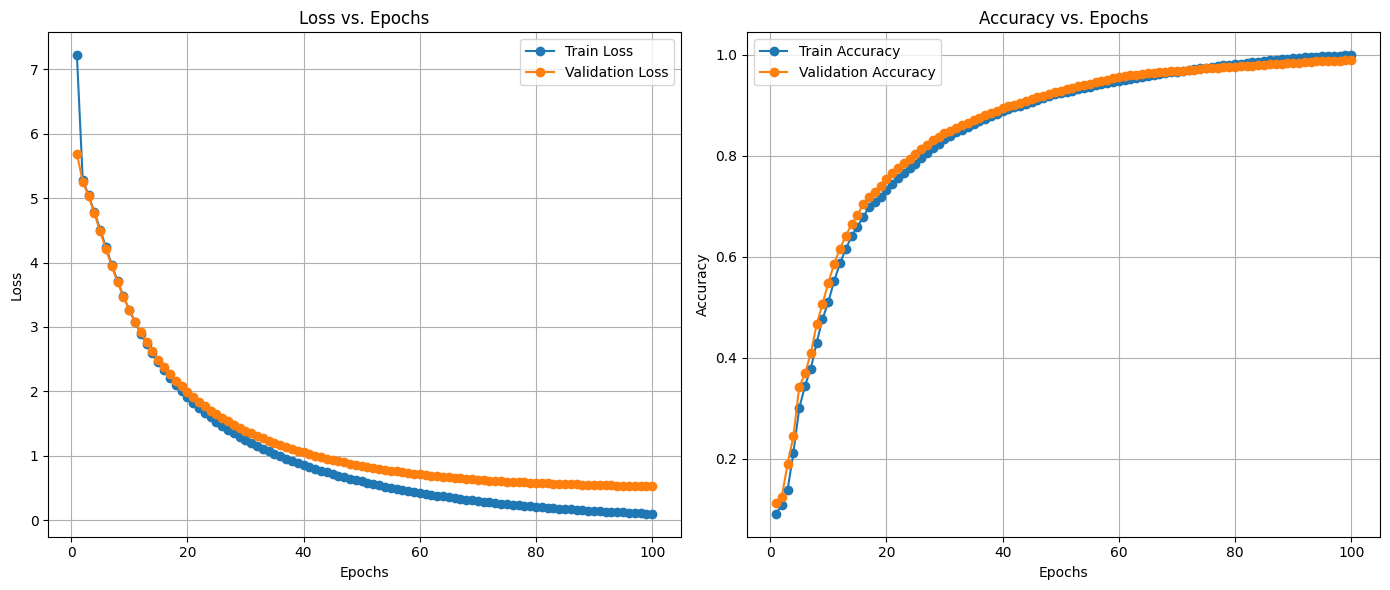

In [75]:
# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 128
epochs = 100
batch_size = 64

encoder = Encoder(len(word2idx_inputs), embedding_dim, hidden_dim, input_embeddings).to(device)
decoder = Decoder(len(word2idx_outputs), embedding_dim, hidden_dim, output_embeddings).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_outputs['<PAD>'])
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001)

# Separar datos en entrenamiento y validación
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_target_train, decoder_target_val = train_test_split(
    encoder_input_sequences, decoder_input_sequences, decoder_targets, test_size=0.2, random_state=42
)

# Función para calcular accuracy
def calculate_accuracy(outputs, targets):
    pred = torch.argmax(outputs, dim=-1)
    mask = targets != word2idx_outputs['<PAD>']
    correct = (pred == targets) & mask
    accuracy = correct.sum().item() / mask.sum().item()
    return accuracy

# Inicialización de listas para guardar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Entrenamiento
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    total_accuracy = 0

    # Entrenamiento
    for i in range(0, len(encoder_input_train), batch_size):
        encoder_input_batch = torch.tensor(encoder_input_train[i:i + batch_size]).to(device)
        decoder_input_batch = torch.tensor(decoder_input_train[i:i + batch_size]).to(device)
        decoder_target_batch = torch.tensor(decoder_target_train[i:i + batch_size]).to(device)

        optimizer.zero_grad()
        h, c = encoder(encoder_input_batch)
        outputs, _, _ = decoder(decoder_input_batch, h, c)

        loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_target_batch.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, decoder_target_batch)

    avg_train_loss = total_loss / (len(encoder_input_train) // batch_size)
    avg_train_accuracy = total_accuracy / (len(encoder_input_train) // batch_size)

    # Validación
    encoder.eval()
    decoder.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for i in range(0, len(encoder_input_val), batch_size):
            encoder_input_batch = torch.tensor(encoder_input_val[i:i + batch_size]).to(device)
            decoder_input_batch = torch.tensor(decoder_input_val[i:i + batch_size]).to(device)
            decoder_target_batch = torch.tensor(decoder_target_val[i:i + batch_size]).to(device)

            h, c = encoder(encoder_input_batch)
            outputs, _, _ = decoder(decoder_input_batch, h, c)

            val_loss += criterion(outputs.view(-1, outputs.size(-1)), decoder_target_batch.view(-1).long()).item()
            val_accuracy += calculate_accuracy(outputs, decoder_target_batch)

    avg_val_loss = val_loss / (len(encoder_input_val) // batch_size)
    avg_val_accuracy = val_accuracy / (len(encoder_input_val) // batch_size)

    # Almacenar métricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")

# Gráficos de métricas
plt.figure(figsize=(14, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Grardado del modelo:

In [76]:
# Guardar el modelo
def save_model(encoder, decoder, encoder_filename='encoder.pkl', decoder_filename='decoder.pkl'):
    torch.save(encoder.state_dict(), encoder_filename)
    torch.save(decoder.state_dict(), decoder_filename)
    print(f"Modelos guardados en {encoder_filename} y {decoder_filename}")

# Al final del entrenamiento, guarda los modelos
save_model(encoder, decoder)

Modelos guardados en encoder.pkl y decoder.pkl


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder. Inferencia con Temperatura

In [ ]:
def temperature_sampling(logits, temperature=1.0):
    """
    Ajusta las probabilidades usando temperature sampling.
    logits: logits generados por el modelo (antes de aplicar softmax).
    temperature: valor de temperatura para ajustar la aleatoriedad.
    """
    logits = logits / temperature  # Ajustamos los logits con la temperatura
    probabilities = F.softmax(logits, dim=-1)  # Convertimos a probabilidades
    return probabilities

def answer_me(sentence, encoder, decoder, temperature=1.0):
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Convertimos la frase en secuencia de índices
        seq = sentences_to_sequences([sentence], word2idx_inputs, max_input_len)
        h, c = encoder(torch.tensor(seq).to(device))  # Codificación de la entrada
        target_seq = torch.tensor([[word2idx_outputs['<START>']]]).to(device)  # Secuencia de inicio

        decoded_sentence = []
        
        for _ in range(max_output_len):
            output, h, c = decoder(target_seq, h, c)  # Decodificación
            logits = output[0, -1]  # Obtenemos los logits de la última palabra generada
            
            # Aplicamos temperature sampling
            probabilities = temperature_sampling(logits, temperature=temperature)
            
            # Seleccionamos la palabra aleatoria basada en las probabilidades ajustadas
            word_idx = torch.multinomial(probabilities, 1).item()  # Selección aleatoria
            
            # Si encontramos el token de fin de secuencia, detenemos la generación
            if word_idx == word2idx_outputs['<END>']:
                break
            
            decoded_sentence.append(idx2word_outputs[word_idx])
            target_seq = torch.tensor([[word_idx]]).to(device)  # Actualizamos la secuencia de entrada para el siguiente paso

        return ' '.join(decoded_sentence)

# Ejemplo de inferencia con temperatura
print(answer_me("do you like pizza?", encoder, decoder, temperature=1.5))


leningrad frm law center administration nikalna planning spend spend train clients 4 florida starting prancing video pepper something too too too too too too too too too too too


### Resúmen:

**Carga y preparación de datos:**

1. Importación de un conjunto de librerías necesarias: os, gdown, json, re, numpy, Counter, y librerías de PyTorch (torch y nn).
2. Descarga del archivo data_volunteers.json que contiene los datos del desafío.
3. Luego se carga el archivo JSON y se limpia el texto de las conversaciones usando expresiones regulares para hacer las frases más uniformes (convertir palabras contraídas en su forma completa, eliminar caracteres no alfabéticos, etc.).

**Preprocesamiento:**

1. Construcción de los vocabularios de las oraciones de entrada y salida (utilizando las funciones build_vocab).
2. Mapeado de cada palabra a un índice (palabras desconocidas son reemplazadas por un token <UNK>).
3. Preparación las secuencias de entrada y salida, convirtiendo las oraciones en índices correspondientes, y se ajustan para tener un tamaño máximo predefinido (max_len).

**Preparación de los embeddings:**

1. Carga los embeddings preentrenados de GloVe (Global Vectors for Word Representation), que son vectores de palabras preentrenados con el propósito de mejorar la representación de las palabras en el modelo.
2. Crga y asignación de cada palabra de los vocabularios respectivos (de entrada y salida).

**Entrenamiento del modelo (Encoder-Decoder con LSTM):**

1. Define la clase Encoder (para convertir la entrada en un vector de contexto) y Decoder (para generar la respuesta a partir de ese contexto).

|Elemento| Objetivo                                                                                                                              |
|--------|---------------------------------------------------------------------------------------------------------------------------------------|
|Encoder | usa embeddings y LSTM para codificar la entrada.                                                                                      |
|Decoder | usa embeddings y LSTM para generar la salida, y una capa Linear para predecir la probabilidad de la siguiente palabra en la secuencia.|

2. Configura el dispositivo (GPU si está disponible) y se definen los hiperparámetros como el tamaño de la capa oculta y el número de épocas.
3. El modelo es entrenado con CrossEntropyLoss y el optimizador Adam. Durante el entrenamiento, se calculan las métricas de pérdida (Loss) y precisión (Accuracy) tanto en los datos de entrenamiento como de validación.

**Inferencia (Generación de respuestas):**

1. Después del entrenamiento, se define una función *answer_me* para generar respuestas a partir de entradas. Esta función toma una oración de entrada, la pasa por el Encoder y usa el Decoder para generar una secuencia de salida (respuesta). También se agrega Temperatura > 1 para agregar la aleatoriedad al resultado.
2. Se utiliza un enfoque de decodificación paso a paso, donde en cada paso se predice una palabra y se usa esa predicción para predecir la siguiente.

**Aspectos importantes:**

1. Durante el entrenamiento, las pérdidas y las precisiones de entrenamiento y validación se almacenan y se grafican al final.
2. Los modelos entrenados (Encoder y Decoder) se guardan en archivos para poder ser reutilizados más tarde.

### Observaciones:

Analizando las gráficas de pérdida se ve una convergencia a 0 por parte de *train* y a 0,5 por parte de *validation*, sin observar en esta última un aumento que indique sobreajuste.

Por otro lado, analizando las curvas de accuracy de *train* y *validation* ambas convergen a 1, lo cual es muy buen resultado. No exixte una diferencia marcada entre las curvas ni se alejan demasiado con respecto al valor optimo, apoyando la idea de que no se genera ni sobreajuste ni subjasute.

No necesariamente, esto es determinante de buen desempeño. Es posible, que el modelo haya aprendido haciendo hincapié en algunos términos del dataset, especialmente si las clases no están balanceadas.